# Testing Synthetic MOXSI Data

In [158]:
import warnings
from collections import OrderedDict

from scipy.io import readsav
import matplotlib.pyplot as plt
import astropy.wcs
import astropy.units as u
import astropy.constants
from astropy.coordinates import SkyCoord,SpectralCoord
import sunpy
from sunpy.coordinates import get_earth,Helioprojective
from sunpy.image.transform import affine_transform
import numpy as np
import ndcube
import sunpy.map
from astropy.visualization import ImageNormalize,SqrtStretch,LogStretch,quantity_support
from IPython.display import HTML

Define some useful functions.

In [27]:
# The following numbers are from Jake and Albert:
CDELT_SPACE = 5.66 * u.arcsec / u.pix
CDELT_WAVE = 55 * u.milliangstrom / u.pix
# The units are from Athiray (and the proposal figure)
BUNIT = 'ph / (pix s)'

In [28]:
@u.quantity_input
def construct_rot_matrix(angle:u.deg):
    return np.array([[np.cos(angle), -np.sin(angle), np.sin(angle)],
                     [np.sin(angle), np.cos(angle), -np.cos(angle)],
                     [0, 0, 1]])

In [29]:
def rmatrix_to_pcij(rmatrix):
    pcij_keys = {}
    for i in range(rmatrix.shape[0]):
        for j in range(rmatrix.shape[1]):
            pcij_keys[f'PC{i+1}_{j+1}'] = rmatrix[i,j]
    return pcij_keys

In [30]:
@u.quantity_input
def rotate_image(data, rmatrix, order=4, missing=0.0,):
    if order not in range(6):
        raise ValueError("Order must be between 0 and 5.")

    # Calculate the shape in pixels to contain all of the image data
    extent = np.max(np.abs(np.vstack((data.shape @ rmatrix,
                                      data.shape @ rmatrix.T))), axis=0)

    # Calculate the needed padding or unpadding
    diff = np.asarray(np.ceil((extent - data.shape) / 2), dtype=int).ravel()
    # Pad the image array
    pad_x = int(np.max((diff[1], 0)))
    pad_y = int(np.max((diff[0], 0)))

    new_data = np.pad(data,
                      ((pad_y, pad_y), (pad_x, pad_x)),
                      mode='constant',
                      constant_values=(missing, missing))

    # All of the following pixel calculations use a pixel origin of 0

    pixel_array_center = (np.flipud(new_data.shape) - 1) / 2.0

    # Apply the rotation to the image data
    new_data = affine_transform(new_data.T,
                                np.asarray(rmatrix),
                                order=order,
                                scale=1.0,
                                image_center=np.flipud(pixel_array_center),
                                recenter=False,
                                missing=missing,
                                use_scipy=True).T

    # Unpad the array if necessary
    unpad_x = -np.min((diff[1], 0))
    if unpad_x > 0:
        new_data = new_data[:, unpad_x:-unpad_x]
    unpad_y = -np.min((diff[0], 0))
    if unpad_y > 0:
        new_data = new_data[unpad_y:-unpad_y, :]

    return new_data

In [31]:
def to_overlappogram(cube, dispersion_angle=0*u.deg, clip=True, order=0):
    """
    Flatten intensity cube into an overlappogram such that the latitude and wavelength
    directions overlap. The array is clipped such that it starts halfway (in latitude)
    through the first wavelength slice and ends halfway through the last wavelength
    slice.

    TODO: return an NDCube with an appropriate WCS

    TODO: generalize such that the dispersion direction can be along any axis or even any
    non-orthogonal path through lon,lat space

    Parameters
    ----------
    dispersion_angle : `float`, optional
        Angle between the dispersion axis and the latitude world coordinate. The dispersion axis
        is always aligned with the y-like (row-indexing) pixel axis. A dispersion angle of 0
        means that the dispersion is completely latitudinal.
    clip : `bool`, optional
        If true, ensure that the dispersion direction has the same shape as the wavelength
        dimension.
    """
    if dispersion_angle % (360*u.deg) == 0:
        rot_data = cube.data
    else:
        rmatrix = construct_rot_matrix(dispersion_angle)
        # apply the necessary rotation to every slice in the cube.
        # this is an overly complicated way to do the rotation, but
        # will suffice for now
        layers = []
        for d in cube.data:
            layers.append(rotate_image(d, rmatrix[:2,:2], order=order))
        rot_data = np.array(layers)
    shape = rot_data.shape
    n_y = int(shape[0] + shape[1])
    n_x = int(shape[2])
    overlappogram = np.zeros((n_y, n_x))
    for i in range(shape[0]):
        overlappogram[i:(i+shape[1]), :] += rot_data[i, :, :]
    if clip:
        # Clip to desired range
        # When shape[1] is even, clip_1 == clip_2
        # When shape[1] is odd, we arbitrarily shift down by a half index at the short wavelength end
        # and up a half at the long wavelength end such that the latitude/wavelength dimension is 
        # cropped appropriately.
        clip_1 = int(np.floor(shape[1]/2))
        clip_2 = int(np.ceil(shape[1]/2))
        # Add stuff in here to make a WCS???
        overlappogram = overlappogram[clip_1:(overlappogram.shape[0]-clip_2),:]

    return overlappogram  * cube.unit

In [32]:
def strided_overlappogram(overlappogram):
    """
    Return a "strided" version of the overlappogram array.
    
    For an overlappogram image of shape (N_lam, N_pix), this
    function creates an array of dimension (N_lam, N_lam, N_pix)
    where each layer is a view of the original array. In other
    words, the values at (k,i,j) and (k+1,i,j) point to the
    same place in memory.
    """
    return np.lib.stride_tricks.as_strided(
        overlappogram,
        shape=overlappogram.shape[:1]+overlappogram.shape,
        strides=(0,)+overlappogram.strides,
        writeable=False
    )

In [33]:
def make_moxsi_ndcube(data, wavelength):
    # Here, assume that the data cube has three dimensions and that
    # the first dimension corresponds to wavelength, then latitude,
    # then longitude.
    moxsi_wcs = {
        'CRVAL1': 0, # Assume for now that the sun is at the center of the image.
        'CRVAL2': 0, # Assume for now that the sun is at the center of the image.
        'CRVAL3': wavelength[0],
        'CRPIX1': (data.shape[2] + 1) / 2,
        'CRPIX2': (data.shape[1] + 1) / 2,
        'CRPIX3': 1,
        'CDELT1': CDELT_SPACE.to('arcsec / pix').value,
        'CDELT2': CDELT_SPACE.to('arcsec / pix').value,
        'CDELT3': CDELT_WAVE.to('angstrom / pix').value,
        'CUNIT1': 'arcsec',
        'CUNIT2': 'arcsec',
        'CUNIT3': 'angstrom',
        'CTYPE1': 'HPLN-TAN',
        'CTYPE2': 'HPLT-TAN',
        'CTYPE3': 'WAVE',
    }
    wcs = astropy.wcs.WCS(moxsi_wcs,)
    return ndcube.NDCube(data, wcs=wcs, unit=BUNIT)

Read in some synthetic data

In [9]:
#flare_feldman = readsav('../data/forDan_MOXSI_DAATA_X1Class_flare_Feldman.sav')
#flare_scott = readsav('../data/forDan_MOXSI_DAATA_X1Class_flare_scott2015_scaledup.sav')
moxsi_data = readsav('../data/forDan_MOXSI_DATA_09112020_0440_feldman.sav')
#ar_scott = readsav('../data/forDan_MOXSI_DATA_09112020_0440_scott2015_scaledup.sav')

Now make a datacube out of it.

In [10]:
moxsi_cube = make_moxsi_ndcube(moxsi_data['moxsi1_img'], moxsi_data['cubixss_wave'])

  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]


<WCSAxesSubplot:>

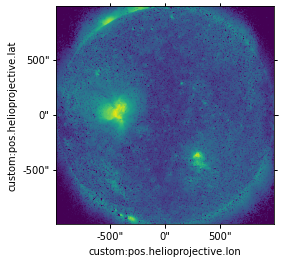

In [11]:
moxsi_cube[500,...].plot(norm=ImageNormalize(stretch=LogStretch()))

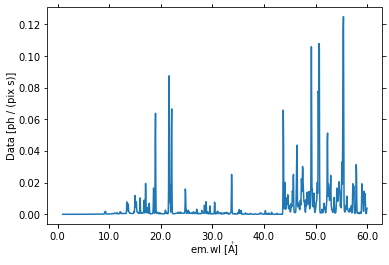

In [12]:
ax = moxsi_cube[:,175,175].plot()
ax.coords[0].set_format_unit(u.angstrom)
ax.coords[0].set_major_formatter('x.x')

Now, the challenge is how to represent this as an overlappogram. We can fairly easily flatten the datacube into something that looks like our overlappogram

In [28]:
moxsi_overlappogram_array = to_overlappogram(moxsi_cube,)

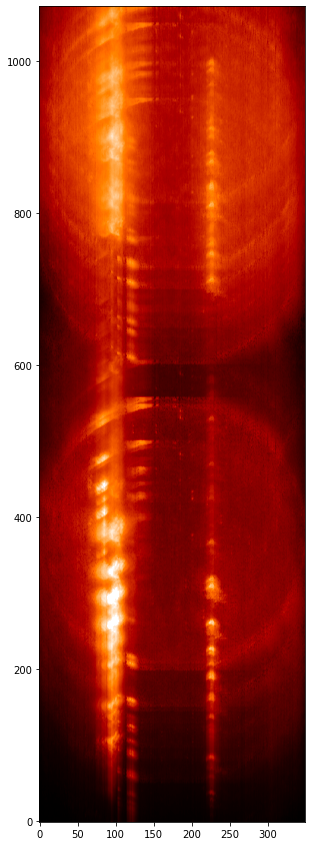

In [29]:
plt.figure(figsize=(5,15))
plt.imshow(moxsi_overlappogram_array, norm=ImageNormalize(vmax=1e2,stretch=LogStretch()), origin='lower', cmap='hinodexrt')

We can also plot a "spectra" by summing along the columns.

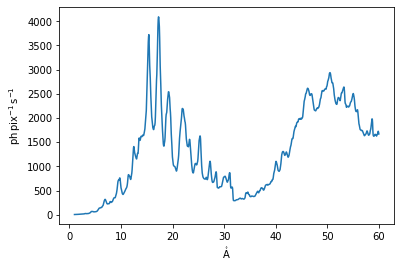

In [30]:
overlap_spectra = moxsi_overlappogram_array.sum(axis=1)
with quantity_support():
    plt.plot(moxsi_cube.axis_world_coords(0)[0].to('angstrom'),overlap_spectra)

But what about the WCS information? This is just an array with no coordinates. How do we encode this into the WCS?

Below, let's try a series of pretty bad ideas.

## Bad Idea 1: Manually increment the reference pixel

Our wavelength axis is aligned along our dispersion axis. In this case, the dispersion axis is aligned with latitiude (generally speaking, this will not be true). Thus, when we increment in wavelength, we also want to increment in latitude.

One way to think about this is we want to move the center of the FOV when we slice in wavelength such that the FOV (in lat,lon) is centered on our selected pixel.

In the case we describe above, wavelength only varies with latitude so we can increment the reference pixel corresponding to latitude and leave the longitude pixel untouched.

In [31]:
def make_bad_overlappogram_map(cube, k):
    wcs = astropy.wcs.WCS({
        'CRVAL1': 0,
        'CRVAL2': 0,
        'CRPIX1': cube.wcs.wcs.crpix[0],
        'CRPIX2': k+1,
        'CDELT1': cube.wcs.wcs.cdelt[0],
        'CDELT2': cube.wcs.wcs.cdelt[1],
        'CUNIT1': cube.wcs.wcs.cunit[0].to_string(),
        'CUNIT2': cube.wcs.wcs.cunit[1].to_string(),
        'CTYPE1': cube.wcs.wcs.ctype[0],
        'CTYPE2': cube.wcs.wcs.ctype[1],
    })
    bad_map = sunpy.map.Map(to_overlappogram(cube), wcs)
    bad_map.plot_settings['cmap'] = 'hinodexrt'
    bad_map.plot_settings['norm'] = ImageNormalize(stretch=LogStretch())
    return bad_map

Let's choose the first wavelength, $k=0$

 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


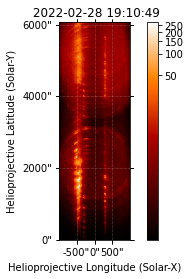

In [32]:
make_bad_overlappogram_map(moxsi_cube,0).peek()

We can also draw a grid

 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


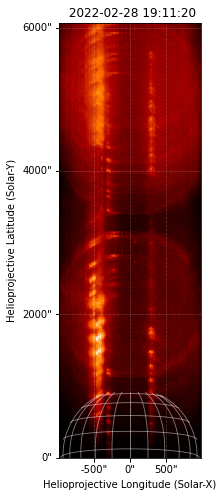

In [33]:
plt.figure(figsize=(3,8))
bm = make_bad_overlappogram_map(moxsi_cube,0)
bm.plot()
_ = bm.draw_grid()

What if we instead select the wavelength which maximizes our spectra?

 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


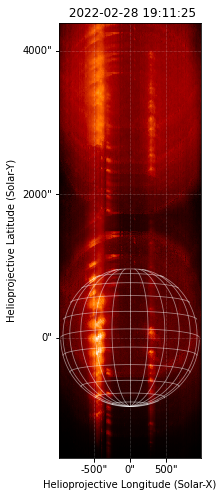

In [34]:
kmax = np.argmax(overlap_spectra)
plt.figure(figsize=(3,8))
bm = make_bad_overlappogram_map(moxsi_cube,kmax)
bm.plot()
_ = bm.draw_grid()

Note that we could also crop this image to get only that image that is centered on the wavelength of interest

In [35]:
bm_cropped = bm.submap(SkyCoord(-1000,-1000,unit='arcsec',frame=bm.coordinate_frame),
                       width=2000*u.arcsec,height=2000*u.arcsec)

 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


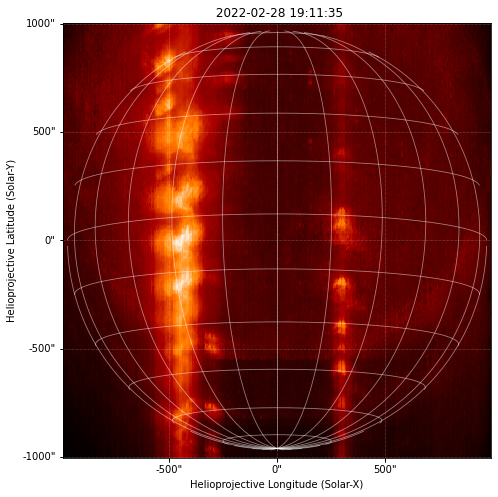

In [36]:
plt.figure(figsize=(8,8))
bm_cropped.plot()
_ = bm_cropped.draw_grid()

This kind of gives us what we want, but has many problems:

* does not work in any general way (what if the dispersion axis is aligned differently?)
* separate WCS for each wavelength
* No real ability to "slice" in wavelength
* Each WCS is separate

## Bad Idea 2: Combine these with a `NDCubeSequence`

In [39]:
def make_slice_wcs(data,wave,k):
    return astropy.wcs.WCS({
        'CRVAL1': 0,
        'CRVAL2': 0,
        'CRVAL3': wave[k].to('angstrom').value,
        'CRPIX1': (data.shape[2] + 1) / 2,
        'CRPIX2': k+1,
        'CRPIX3': 1,
        'CDELT1': CDELT_SPACE.to('arcsec / pix').value,
        'CDELT2': CDELT_SPACE.to('arcsec / pix').value,
        'CDELT3': CDELT_WAVE.to('angstrom / pix').value,
        'CUNIT1': 'arcsec',
        'CUNIT2': 'arcsec',
        'CUNIT3': 'angstrom',
        'CTYPE1': 'HPLN-TAN',
        'CTYPE2': 'HPLT-TAN',
        'CTYPE3': 'WAVE',
    })


def make_cube_seq(cube):
    # Flatten to overlappogram
    overlap = to_overlappogram(cube)
    # Make strided 3D array
    wave = cube.axis_world_coords(0)[0].to('angstrom')
    strided_overlap = strided_overlappogram(overlap)
    # Construct a "cube" for each wavelength
    cubes = []
    for i in range(wave.shape[0]):
        slice_data = strided_overlap[i:i+1,...]
        slice_wcs = make_slice_wcs(slice_data,wave,i)
        cubes.append(ndcube.NDCube(slice_data,wcs=slice_wcs,unit=cube.unit))
    # Combine them into a sequence where the common axis is wavelength
    return ndcube.NDCubeSequence(cubes,common_axis=0)

In [40]:
overlap_seq = make_cube_seq(moxsi_cube)

  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]


In [41]:
overlap_seq

NDCubeSequence
--------------
Dimensions:  (<Quantity 1073. pix>, <Quantity 1. pix>, <Quantity 1073. pix>, <Quantity 350. pix>)
Physical Types of Axes: [('meta.obs.sequence',), ('em.wl',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Common Cube Axis: 0

In [42]:
overlap_seq.cube_like_dimensions

<Quantity [1073., 1073.,  350.] pix>

We can now index this object along the first axis such that it returns to us a view of the array, but with the origin shifted according to the selected wavelength.

In [43]:
overlap_seq.index_as_cube[kmax,...]

NDCube
------
Dimensions: [1073.  350.] pix
Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: ph / (pix s)
Data Type: float64

<WCSAxesSubplot:>

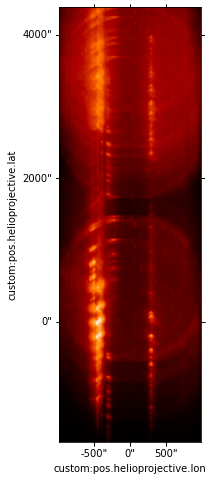

In [44]:
plt.figure(figsize=(3,8))
overlap_seq.index_as_cube[kmax,...].plot(cmap='hinodexrt',norm=ImageNormalize(stretch=LogStretch()))

<WCSAxesSubplot:>

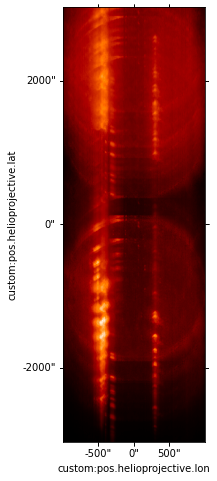

In [45]:
plt.figure(figsize=(3,8))
overlap_seq.index_as_cube[1073//2,...].plot(cmap='hinodexrt',norm=ImageNormalize(stretch=LogStretch()))

Note that we haven't actually duplicated the array $N_{\lambda}$ times as that would be a massive waste of memory. Instead, we've created an array with "0-stride" in the wavelength dimension such that every slice (in wavelength) points to the same place in memory.

There are a few ways to verify this with `numpy`.

In [46]:
p0,_ = overlap_seq.index_as_cube[0].data.__array_interface__['data']

In [47]:
p1,_ = overlap_seq.index_as_cube[1].data.__array_interface__['data']

In [48]:
p0 == p1

True

In [49]:
np.shares_memory(overlap_seq.index_as_cube[0].data,
                 overlap_seq.index_as_cube[1].data)

True

In [50]:
overlap_seq.index_as_cube[0].data.base is overlap_seq.index_as_cube[1].data.base

True

If we can load these into a map sequence, we can also easily animate them (animate NDCubeSequences is a pain).

In [51]:
maps = []
wave = moxsi_cube.axis_world_coords(0)[0]
earth = get_earth()
indices = list(range(int(overlap_seq.cube_like_dimensions[0].value)))
for i in indices[::50]:
    sl = overlap_seq.index_as_cube[i,...]
    m = sunpy.map.Map(sl.data, sl.wcs.low_level_wcs._wcs)
    m.meta['WAVELNTH'] = wave[i].to('angstrom').value
    m.meta['WAVEUNIT'] = wave.to('angstrom').unit.to_string()
    m.meta['DATE-AVG'] = earth.obstime.isot
    m.meta['HGLN_OBS'] = earth.lon.to('deg').value
    m.meta['HGLT_OBS'] = earth.lat.to('deg').value
    m.meta['DSUN_OBS'] = earth.radius.to('m').value
    m.meta['RSUN_REF'] = astropy.constants.R_sun.to('m').value
    m.plot_settings['cmap'] = 'hinodexrt'
    m.plot_settings['norm'] = ImageNormalize(stretch=LogStretch())
    maps.append(m)
map_seq = sunpy.map.MapSequence(maps, sortby=None,derotate=False)

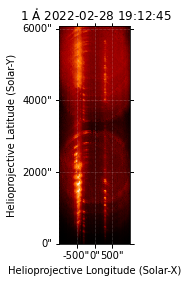

In [52]:
ani = map_seq.plot()

In [53]:
HTML(ani.to_jshtml())

## Slightly Better Idea 3: Encode degeneracy in the WCS

We can use the `PCi_j` formalism to couple the wavelength and latitude dimensions. Say we have three pixel dimensions $(p_1,p_2,p_3)$ corresponding to the columns ($x$-like), rows ($y$-like), and layers ("0-stride" dimension) and three world dimensions $(\theta_x,\theta_y,\lambda)$.

The conversion between the world and pixel coordinates (ignoring for now the complexities of the actual celestial coordinates),

$$
\theta_x = \Delta_x(p_1 - r_1),\\
\theta_y = \Delta_y(p_2 - p_3),\\
\lambda = \Delta_\lambda(p_3 - r_3).\\
$$

Skipping some algebra, this results in the following `PCi_j` matrix,

$$
M =
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & -1 \\
0 & 0 & 1
\end{bmatrix}
$$

This formalism is described in detail in Greisen and Calabretta (2002). Note that because the identity is the default value for `PCi_j`, we only need specify the off-diagonal elements here, in this case `PC2_3=-1`.

In [55]:
# Flatten to overlappogram
moxsi_overlap = to_overlappogram(moxsi_cube)
# Make strided 3D array
wave = moxsi_cube.axis_world_coords(0)[0].to('angstrom')
moxsi_strided_overlap = strided_overlappogram(moxsi_overlap)
degen_wcs = astropy.wcs.WCS({
    'WCSAXES': 3,
    'NAXIS1': moxsi_strided_overlap.shape[2],
    'NAXIS2': moxsi_strided_overlap.shape[1],
    'NAXIS3': moxsi_strided_overlap.shape[0],
    'CDELT1': CDELT_SPACE.to('arcsec / pix').value,
    'CDELT2': CDELT_SPACE.to('arcsec / pix').value,
    'CDELT3': CDELT_WAVE.to('angstrom / pix').value,
    'CUNIT1': 'arcsec',
    'CUNIT2': 'arcsec',
    'CUNIT3': 'Angstrom',
    'CTYPE1': 'HPLN-TAN',
    'CTYPE2': 'HPLT-TAN',
    'CTYPE3': 'WAVE',
    'CRPIX1': (moxsi_strided_overlap.shape[2] + 1)/2,
    'CRPIX2': (moxsi_strided_overlap.shape[1] + 1)/2,
    'CRPIX3': (moxsi_strided_overlap.shape[0] + 1)/2,
    'CRVAL1': 0,
    'CRVAL2': 0,
    'CRVAL3': ((wave[0] + wave[-1])/2).to('angstrom').value,
    'PC2_3': -1,  # i==j assumed 1, i!=j assumed 0 unless explicitly stated
})
degen_cube = ndcube.NDCube(moxsi_strided_overlap, wcs=degen_wcs)

Note that our longitude changes as we move in wavelength.

<WCSAxesSubplot:>

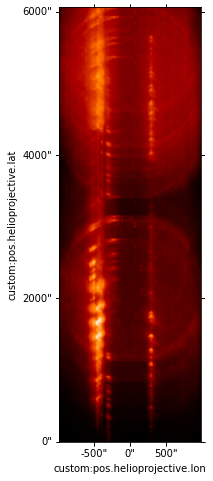

In [56]:
plt.figure(figsize=(3,8))
degen_cube[0,].plot(cmap='hinodexrt',norm=ImageNormalize(stretch=LogStretch()))

<WCSAxesSubplot:>

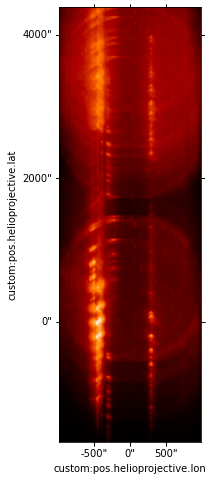

In [58]:
plt.figure(figsize=(3,8))
degen_cube[kmax].plot(cmap='hinodexrt',norm=ImageNormalize(stretch=LogStretch()))

<WCSAxesSubplot:>

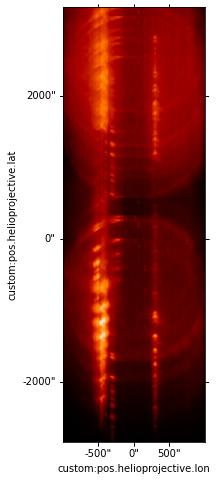

In [131]:
plt.figure(figsize=(3,8))
degen_cube[500,].plot(cmap='hinodexrt',norm=ImageNormalize(stretch=LogStretch()))

Additionally, note that when we plot a slice in wavelength, both the longitude and wavelength axes vary and the alignment between wavelength and latitude varies latitudinally.

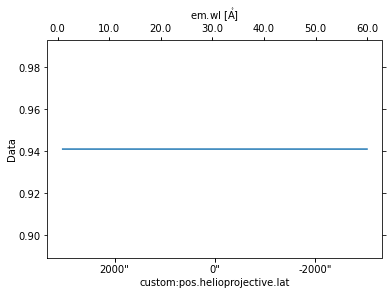

In [83]:
ax = degen_cube[:,1073//2,175].plot()
ax.coords[2].set_format_unit(u.angstrom)
ax.coords[2].set_major_formatter('x.x')

<Figure size 216x576 with 0 Axes>

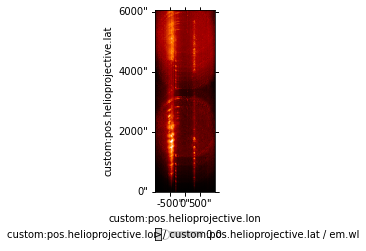

In [57]:
plt.figure(figsize=(3,8))
ani = degen_cube[:50,...].plot(cmap='hinodexrt',norm=ImageNormalize(stretch=LogStretch()))

In [58]:
fani = ani.get_animation()

In [60]:
HTML(fani.to_jshtml())

## Possibly Good Idea 4: Generalized `PCi_j` matrix

Now the question is, can we come up with a generalized prescription for construction a `PCi_j` matrix for an arbitrary orientation of the dispersion axis.

In [324]:
moxsi_cube.wcs.wcs.cunit

['deg', 'deg', 'm']

In [328]:
(wave[1]-wave[0]).to('mAngstrom')

<Quantity 55. mAngstrom>

In [34]:
def construct_generalized_overlappogram(cube, angle):
    rmatrix = construct_rot_matrix(angle)
    # Flatten to overlappogram
    moxsi_overlap = to_overlappogram(cube, dispersion_angle=angle)
    # Make strided 3D array
    wave = cube.axis_world_coords(0)[0].to('angstrom')
    moxsi_strided_overlap = strided_overlappogram(moxsi_overlap)
    wcs_keys = {
        'WCSAXES': 3,
        'NAXIS1': moxsi_strided_overlap.shape[2],
        'NAXIS2': moxsi_strided_overlap.shape[1],
        'NAXIS3': moxsi_strided_overlap.shape[0],
        'CDELT1': CDELT_SPACE.to('arcsec / pix').value,
        'CDELT2': CDELT_SPACE.to('arcsec / pix').value,
        'CDELT3': CDELT_WAVE.to('angstrom / pix').value,
        'CUNIT1': 'arcsec',
        'CUNIT2': 'arcsec',
        'CUNIT3': 'Angstrom',
        'CTYPE1': 'HPLN-TAN',
        'CTYPE2': 'HPLT-TAN',
        'CTYPE3': 'WAVE',
        'CRPIX1': (moxsi_strided_overlap.shape[2] + 1)/2,
        'CRPIX2': (moxsi_strided_overlap.shape[1] + 1)/2,
        'CRPIX3': (moxsi_strided_overlap.shape[0] + 1)/2,
        'CRVAL1': 0,
        'CRVAL2': 0,
        'CRVAL3': ((wave[0] + wave[-1])/2).to('angstrom').value,
    }
    pcij_keys = rmatrix_to_pcij(rmatrix)
    for k in pcij_keys:
        wcs_keys[k] = pcij_keys[k]
    wcs = astropy.wcs.WCS(wcs_keys)
    overlap_cube = ndcube.NDCube(moxsi_strided_overlap, wcs=wcs)
    return overlap_cube

In [35]:
moxsi_overlap1 = construct_generalized_overlappogram(moxsi_cube, 0*u.deg)

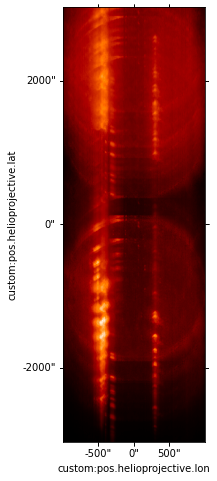

In [335]:
plt.figure(figsize=(3,8))
ax = moxsi_overlap1[1073//2].plot(
    #plot_axes=('x','y'),
    cmap='hinodexrt',
    norm=ImageNormalize(stretch=LogStretch())
)

In [134]:
ax.coords

<CoordinatesMap with 2 world coordinates:

  index                   aliases                       type   unit  wrap format_unit visible
  ----- -------------------------------------------- --------- ---- ----- ----------- -------
      0 custom:pos.helioprojective.lon hpln-tan hpln longitude  deg 180.0      arcsec     yes
      1 custom:pos.helioprojective.lat hplt-tan hplt  latitude  deg  None      arcsec     yes

>

In [153]:
moxsi_overlap2 = construct_generalized_overlappogram(moxsi_cube, 90*u.deg)

In [154]:
moxsi_overlap2.wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  
CRVAL : 0.0  0.0  3.0480000000000002e-09  
CRPIX : 175.5  537.0  537.0  
PC1_1 PC1_2 PC1_3  : 6.12323399573676e-17  -1.0  1.0  
PC2_1 PC2_2 PC2_3  : 1.0  6.12323399573676e-17  -6.1232339957367e-17  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.0015722222222222223  0.0015722222222222223  5.5e-12  
NAXIS : 350  1073  1073

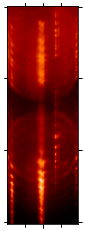

In [156]:
ax = moxsi_overlap2[10,...].plot(
    #plot_axes=('x','y'),
    cmap='hinodexrt',
    norm=ImageNormalize(stretch=LogStretch())
)

In [131]:
ax.coords

<CoordinatesMap with 2 world coordinates:

  index                   aliases                       type   unit  wrap format_unit visible
  ----- -------------------------------------------- --------- ---- ----- ----------- -------
      0 custom:pos.helioprojective.lon hpln-tan hpln longitude  deg 180.0      arcsec     yes
      1 custom:pos.helioprojective.lat hplt-tan hplt  latitude  deg  None      arcsec     yes

>

<WCSAxesSubplot:ylabel='Data'>

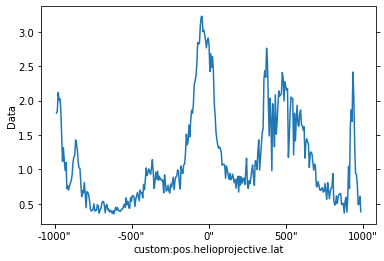

In [64]:
moxsi_overlap2[0,1073//2,:].plot()

In [47]:
moxsi_overlap3 = construct_generalized_overlappogram(moxsi_cube, 45*u.deg)

<WCSAxesSubplot:>

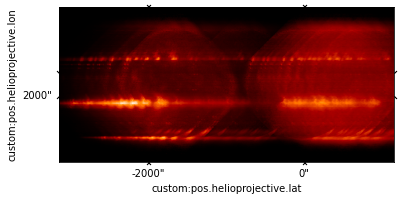

In [61]:
moxsi_overlap3[1073//2].plot(plot_axes=('x','y'),cmap='hinodexrt',norm=ImageNormalize(stretch=LogStretch()))

<WCSAxesSubplot:ylabel='Data'>

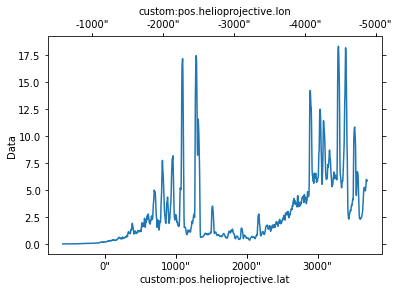

In [57]:
moxsi_overlap3[0,:,100].plot()

In [67]:
moxsi_overlap4 = construct_generalized_overlappogram(moxsi_cube, 5*u.deg)

<WCSAxesSubplot:>

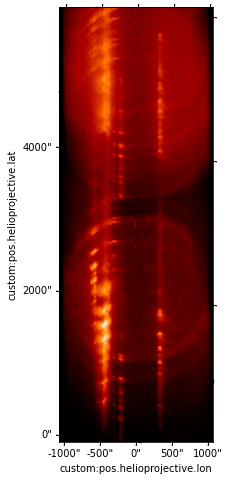

In [113]:
plt.figure(figsize=(4,8))
moxsi_overlap4[0].plot(plot_axes=('y','x'),cmap='hinodexrt',norm=ImageNormalize(stretch=LogStretch()))

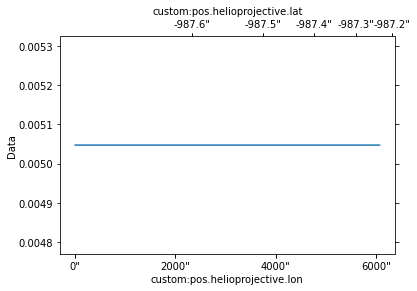

In [96]:
ax = moxsi_overlap2[:,0,0].plot()
ax.coords[2].set_format_unit(u.angstrom)
ax.coords[2].set_major_formatter('x.x')

<WCSAxesSubplot:>

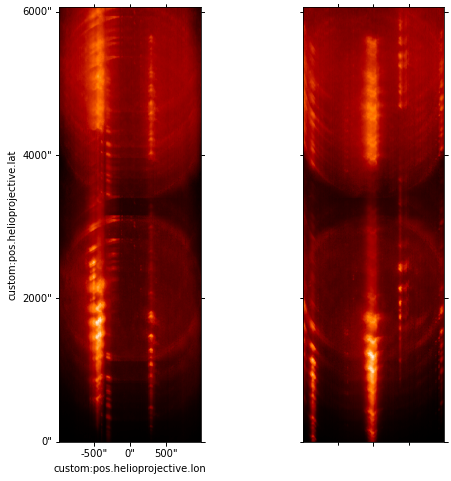

In [121]:
fig = plt.figure(figsize=(8,8))
foo0 = construct_generalized_overlappogram(moxsi_cube,0*u.deg)
foo = construct_generalized_overlappogram(moxsi_cube, 90*u.deg)
ax = fig.add_subplot(121,projection=foo0[0].wcs)
foo0[0].plot(axes=ax,plot_axes=('y','x'),cmap='hinodexrt',norm=ImageNormalize(stretch=LogStretch()))
ax = fig.add_subplot(122,projection=foo[0].wcs)
foo[0].plot(axes=ax,plot_axes=('y','x'),cmap='hinodexrt',norm=ImageNormalize(stretch=LogStretch()))

In [148]:
foo.wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  
CRVAL : 0.0  0.0  3.0480000000000002e-09  
CRPIX : 175.5  537.0  537.0  
PC1_1 PC1_2 PC1_3  : 6.12323399573676e-17  -1.0  1.0  
PC2_1 PC2_2 PC2_3  : 1.0  6.12323399573676e-17  -6.1232339957367e-17  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.0015722222222222223  0.0015722222222222223  5.5e-12  
NAXIS : 350  1073  1073

In [149]:
foo.wcs.axis_correlation_matrix

array([[ True,  True,  True],
       [ True,  True,  True],
       [False, False,  True]])

## Testing Some Cropping Operations

In [300]:
wave = moxsi_cube.axis_world_coords(0)[0]
iwave_min = 1073//2-5
iwave_max = 1073//2+5
ll = [SkyCoord(-20,-20,unit='arcsec',frame=Helioprojective),SpectralCoord(wave[iwave_min])]
ur = [SkyCoord(20,20,unit='arcsec',frame=Helioprojective),SpectralCoord(wave[iwave_max])]
lr = [SkyCoord(20,-20,unit='arcsec',frame=Helioprojective),SpectralCoord(wave[iwave_max])]
ul = [SkyCoord(-20,20,unit='arcsec',frame=Helioprojective),SpectralCoord(wave[iwave_min])]

In [301]:
moxsi_overlap_cropped = moxsi_overlap1.crop(ll,ur,lr,ul)

In [302]:
moxsi_overlap_cropped

NDCube
------
Dimensions: [11. 19.  8.] pix
Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: None
Data Type: float64

<WCSAxesSubplot:>

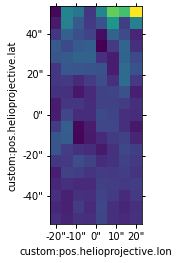

In [332]:
moxsi_overlap_cropped[5,...].plot()

<WCSAxesSubplot:ylabel='Data'>

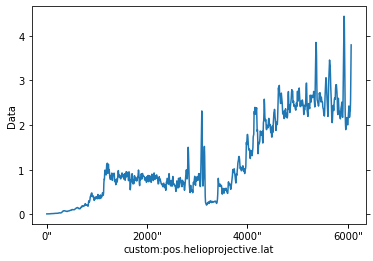

In [184]:
moxsi_overlap_cropped[0,:,1].plot()

In [289]:
moxsi_overlap1.wcs.world_to_pixel(*ll)

(array(170.96643108), array(527.46643107), array(531.))

In [298]:
moxsi_overlap1.wcs.world_to_pixel(SkyCoord(0,20,unit='arcsec',frame=Helioprojective),SpectralCoord(wave[iwave_max]))

(array(174.5), array(544.53356892), array(541.))

<WCSAxesSubplot:>

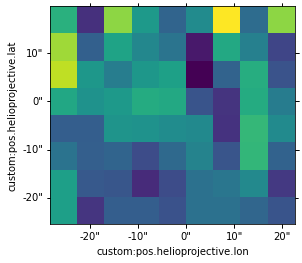

In [299]:
moxsi_overlap1[541,537:545,170:179].plot()

In [295]:
#moxsi_overlap1.wcs.world_to_pixel(*ur)
moxsi_overlap1.wcs.world_to_pixel(SkyCoord(20,20,unit='arcsec',frame=Helioprojective),SpectralCoord(wave[iwave_min]))

(array(178.03356892), array(534.53356893), array(531.))

<WCSAxesSubplot:>

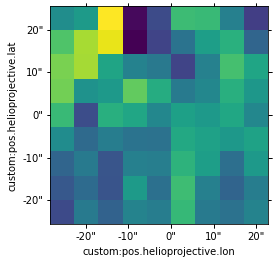

In [297]:
moxsi_overlap1[531,527:536,170:179].plot()

In [286]:
moxsi_overlap1.wcs.pixel_to_world(*moxsi_overlap1.wcs.world_to_pixel(*ur))

[<SkyCoord (Helioprojective: obstime=None, rsun=695700.0 km, observer=None): (Tx, Ty) in arcsec
     (20., 20.)>,
 <SpectralCoord 3.0755e-09 m>]

In [281]:
moxsi_overlap1.wcs.pixel_to_world(178,545,541)

[<SkyCoord (Helioprojective: obstime=None, rsun=695700.0 km, observer=None): (Tx, Ty) in arcsec
     (19.80999994, 22.6399998)>,
 <SpectralCoord 3.0755e-09 m>]

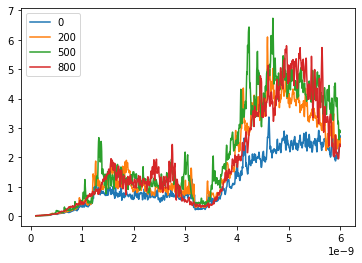

In [266]:
for Tx in [0,200,500,800]:
    p1,p2,p3 = moxsi_overlap1.wcs.world_to_pixel(
        SkyCoord(Tx,0,unit='arcsec',frame=Helioprojective),
        SpectralCoord(wave)
    )
    p1 = p1.astype(int)
    p2 = p2.astype(int)
    p3 = p3.astype(int)
    spec00 = moxsi_overlap1.data[p3,p2,p1]
    plt.plot(wave,spec00,label=Tx)
plt.legend()

In [267]:
p1,p2,p3 = moxsi_overlap1.wcs.world_to_pixel(
    SkyCoord(0,0,unit='arcsec',frame=Helioprojective),
    SpectralCoord(wave)
)

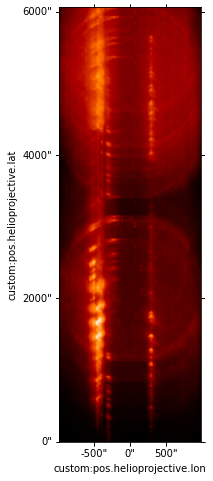

In [269]:
plt.figure(figsize=(3,8))
ax = moxsi_overlap1[0].plot(
    #plot_axes=('x','y'),
    cmap='hinodexrt',
    norm=ImageNormalize(stretch=LogStretch())
)

<WCSAxesSubplot:ylabel='Data'>

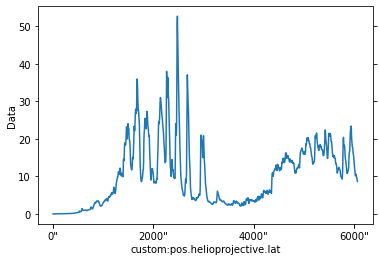

In [277]:
moxsi_overlap1[0,:,80].plot()

In [336]:
m = sunpy.map.Map('/Users/willbarnes/sunpy/data/aia_lev1_131a_2011_02_12t15_00_09_62z_image_lev1.fits')

In [337]:
m.wcs.has_celestial

True

In [338]:
from astropy.wcs.utils import wcs_to_celestial_frame

In [339]:
wcs_to_celestial_frame(m.wcs)

<Helioprojective Frame (obstime=2011-02-12T15:00:09.620, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2011-02-12T15:00:09.620, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.00971981, -6.69174749, 1.47661935e+11)>)>

In [343]:
wcs_to_celestial_frame(moxsi_overlap1.wcs)

<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=None)>

In [344]:
m.wcs.to_header()

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =          2047.380005 / Pixel coordinate of reference point            
CRPIX2  =          2037.920044 / Pixel coordinate of reference point            
PC1_1   =     0.99999706228137 / Coordinate transformation matrix element       
PC1_2   =    0.002423928344853 / Coordinate transformation matrix element       
PC2_1   =   -0.002423928344853 / Coordinate transformation matrix element       
PC2_2   =     0.99999706228137 / Coordinate transformation matrix element       
CDELT1  =  0.00016686055555556 / [deg] Coordinate increment at reference point  
CDELT2  =  0.00016686055555556 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'HPLN-TAN'           / Coordinate type codegnomonic projection        
CTYPE2  = 'HPLT-TAN'        

In [345]:
m.wcs.to_header()

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =          2047.380005 / Pixel coordinate of reference point            
CRPIX2  =          2037.920044 / Pixel coordinate of reference point            
PC1_1   =     0.99999706228137 / Coordinate transformation matrix element       
PC1_2   =    0.002423928344853 / Coordinate transformation matrix element       
PC2_1   =   -0.002423928344853 / Coordinate transformation matrix element       
PC2_2   =     0.99999706228137 / Coordinate transformation matrix element       
CDELT1  =  0.00016686055555556 / [deg] Coordinate increment at reference point  
CDELT2  =  0.00016686055555556 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'HPLN-TAN'           / Coordinate type codegnomonic projection        
CTYPE2  = 'HPLT-TAN'        

In [347]:
foo = sunpy.map.Map(moxsi_cube[1073//2].data,
                    moxsi_cube[1073//2].wcs.low_level_wcs._wcs)

 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


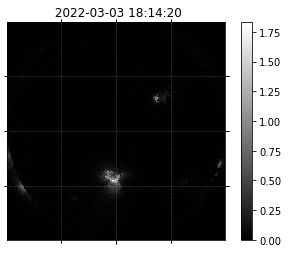

In [351]:
foo.rotate(angle=90*u.deg).peek()

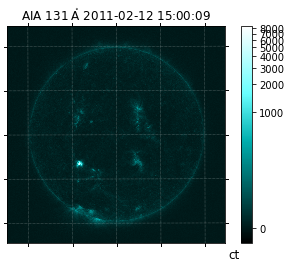

In [353]:
m.rotate(angle=90*u.deg).peek()

In [354]:
import sunpy.data.sample

In [355]:
m = sunpy.map.Map(sunpy.data.sample.AIA_094_IMAGE)

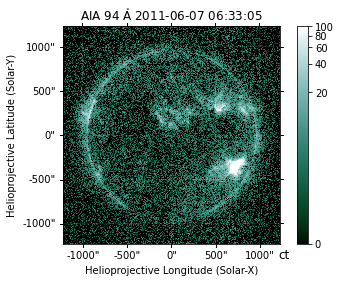

In [358]:
m.peek(vmin=0,vmax=100)

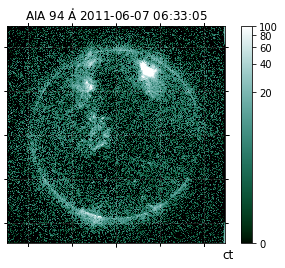

In [380]:
m_rot = m.rotate().rotate(angle=90*u.deg)
m_rot.peek(vmin=0,vmax=1e2)

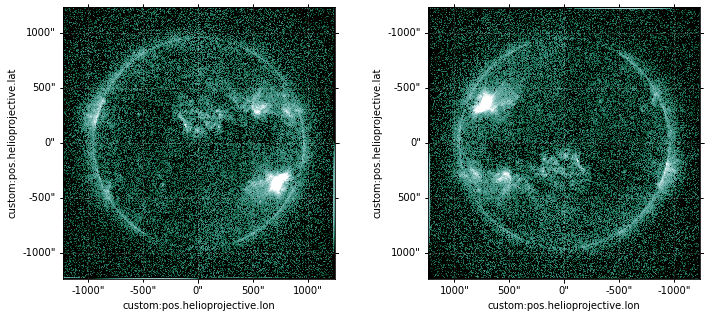

In [400]:
import astropy.units as u
import sunpy.data.sample
import sunpy.map
m = sunpy.map.Map(sunpy.data.sample.AIA_094_IMAGE).rotate()
m_rot = m.rotate(angle=180*u.deg)
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121,projection=m)
m.plot(axes=ax,vmin=0,vmax=1e2,annotate=False)
ax = fig.add_subplot(122,projection=m_rot)
m_rot.plot(axes=ax,vmin=0,vmax=1e2,annotate=False)
lon,lat = ax.coords

<WCSAxesSubplot:>

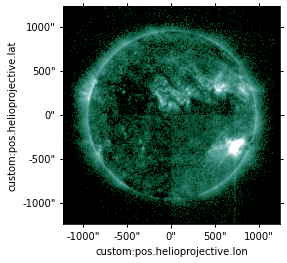

In [401]:
ndcube.NDCube(m.data,m.wcs).plot(norm=ImageNormalize(vmin=0,vmax=1e2,stretch=m.plot_settings['norm'].stretch),
                                 cmap=m.plot_settings['cmap'])

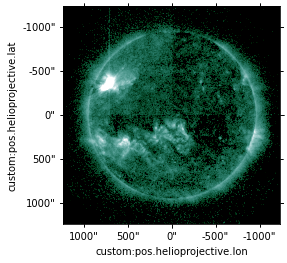

In [402]:
ax = ndcube.NDCube(m_rot.data,m_rot.wcs).plot(
    norm=ImageNormalize(vmin=0,vmax=1e2,stretch=m.plot_settings['norm'].stretch),
    cmap=m.plot_settings['cmap']
)
#ax.coords[0].set_ticklabel_position('all')
#ax.coords[1].set_ticklabel_position('all')